# Fundamentals of Data Visualization
## Using geospatial Data 

sources:
* https://towardsdatascience.com/how-tracking-apps-analyse-your-gps-data-a-hands-on-tutorial-in-python-756d4db6715d
* https://github.com/andyakrn/activities_heatmap/blob/master/garmin_activities_proc.ipynb


In [52]:
import pandas as pd
import gpxpy
import matplotlib.pyplot as plt
import folium


In [2]:
# importing and parsing the gpx file 
gpx_file = open('data/Lunch_Run.gpx', 'r')
gpx = gpxpy.parse(gpx_file)

In [3]:
# check how the data is devided
len(gpx.tracks)
len(gpx.tracks[0].segments)
len(gpx.tracks[0].segments[0].points)

# everything is in points
data = gpx.tracks[0].segments[0].points

In [4]:
# add all information to a dataframe
df = pd.DataFrame(columns=['lon', 'lat', 'alt', 'time'])

for point in data:
    df = df.append({'lon': point.longitude, 'lat' : point.latitude, 'alt' : point.elevation, 'time' : point.time.strftime('%H:%M:%S')}, ignore_index=True)

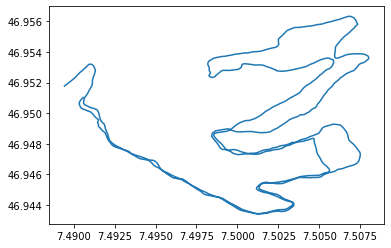

In [5]:
# simple lon/lat plot using matplotlib
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(df['lon'],df['lat'])

fig.savefig('1.png')


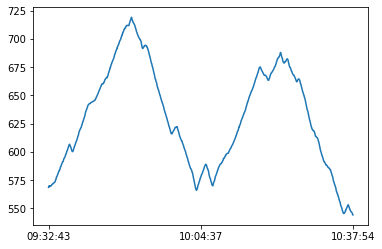

In [6]:
# elevation vs. time
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(df['time'],df['alt'])
ax.set_xticks([0,len(df['time'])/2,len(df['time'])-1])

fig.savefig('2.png')

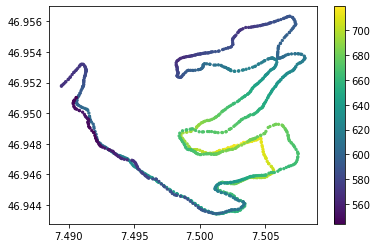

In [8]:
# map elevation on plot
plt.scatter(df['lon'],df['lat'],c=df['alt'],cmap='viridis',s=5)
plt.colorbar()
plt.savefig('3.png')

In [11]:
# Data preparation

#getting the average of lon/lat to get center of map
lon_a = df['lon'].mean()
lat_a = df['lat'].mean()
# adding lon/lat to tuples
points = list(zip(df['lat'],df['lon']))

In [57]:
map = folium.Map( location=[lat_a,lon_a], zoom_start=14)
folium.PolyLine(points, color="red", weight=2.5, opacity=1).add_to(map)

In [58]:
map